# **Vocal Biomarker Estimator for Parkinson’s Disease**

 **Notebook 1/2 - AI-Based Early Detection of Parkinson's Disease from Speech**
### AAI-590 Capstone Project

**Author:** Arifa Kokab  
**Group:** 11 (Solo)  
**Program:** M.Sc. Applied Artificial Intelligence  
**School:** University of San Diego - Shiley-Marcos School of Engineering  

*Launched under CarePath AI Foundation (Non-Profit)*

#INTRODUCTION
This notebook is the first of two in my project titled "Vocal Biomarker Estimator for Parkinson's Disease." Here, the goal is to accurately and reliably screen individuals using voice data to determine if they are likely healthy or have Parkinson’s Disease (PD) using artificial intelligence. If someone is flagged as potentially positive for PD in this first step, the second notebook will then estimate the severity of their condition.

To maximize both performance and reliability, I merged three well-known, publicly available datasets from the UC Irvine Machine Learning Repository:

-

**1. Parkinsons1:**

Voice recordings from 20 individuals with Parkinson’s and 20 healthy controls, collected at Istanbul University. Each subject provided 26 types of voice samples, with features extracted for both classification and severity regression (UPDRS scores available).

*Erdogdu Sakar, B. et al., IEEE Journal of Biomedical and Health Informatics, 2013*

Retreived from: https://archive.ics.uci.edu/dataset/301/parkinson+speech+dataset+with+multiple+types+of+sound+recordings

-

**2. Parkinsons2:**

The Oxford Parkinson's Disease Detection Dataset, containing voice features and status labels for PD and healthy cases.

*Max A. Little, Patrick E. McSharry, Eric J. Hunter, Lorraine O. Ramig (2008).
"Suitability of dysphonia measurements for telemonitoring of Parkinson's disease."
IEEE Transactions on Biomedical Engineering*

Retrieved from: https://archive.ics.uci.edu/dataset/174/parkinsons

-

**3. Parkinsons3:**

The Oxford Parkinson’s Disease Telemonitoring Dataset, offering voice features and physician-rated Unified Parkinson’s Disease Rating Scale (UPDRS) scores for tracking disease severity.

*Athanasios Tsanas, Max A. Little, Patrick E. McSharry, Lorraine O. Ramig (2009).
"Accurate telemonitoring of Parkinson’s disease progression by non-invasive speech tests."
IEEE Transactions on Biomedical Engineering*

Retrieved from: https://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring

-

By merging these datasets, I increased the sample diversity, enhanced the model’s generalizability, and ensured the AI could learn from a wider range of voice patterns and disease states. All data was sourced from the UC Irvine Machine Learning Repository and processed securely in Google Drive.

*This notebook focuses only on screening for PD. If a sample is predicted as positive, a second notebook will estimate how severe the condition is. Both steps together create an accessible and scalable tool for early detection and monitoring of Parkinson’s disease using just voice.*

## Library Imports & Google Drive Setup

In this section, we import all the necessary Python libraries for the project.
- pandas and numpy are used for data manipulation and analysis.
- matplotlib and seaborn are used for data visualization.
- scikit-learn provides tools for machine learning modeling and data preprocessing.
- imblearn is used for handling class imbalance with SMOTE.
- google.colab.drive lets us access datasets stored in Google Drive.
This setup ensures we have all the tools needed for data cleaning, exploration, modeling, and evaluation.


In [21]:
# 1. Core Libraries
import os
import pandas as pd
import numpy as np

# 2. Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Machine Learning & Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE

# 4. Google Colab - Drive Integration
from google.colab import drive, files

# 5. Saving files for Deployment on a Streamlit App using Render
import pickle
import joblib

## Mount Google Drive & Set Paths
Here, we mount our Google Drive to access the datasets for the project.
We define the path to the main folder containing all Parkinson's datasets, then list the files in each subfolder to confirm data availability.
We load the primary data files using pandas, and use a smart loader to handle any unexpected formatting issues.
This ensures our project starts with reliable access to all required data files from Drive.

In [2]:
# Mount my Google Drive to access files
drive.mount('/content/drive')

# Base dataset folder
base_path = '/content/drive/My Drive/Datasets for Capstone Project'

# List all files in each dataset folder (for quick sanity check)
for folder in ['parkinsons1', 'parkinsons2', 'parkinsons3']:
    folder_path = os.path.join(base_path, folder)
    print(f"Files in {folder}:")
    print(os.listdir(folder_path))
    print()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files in parkinsons1:
['train_data.txt', 'test_data.txt']

Files in parkinsons2:
['parkinsons.names', 'parkinsons.data', 'parkinsons_updrs.data', 'parkinsons_updrs.names']

Files in parkinsons3:
['parkinsons_updrs.names', 'parkinsons_updrs.data']



## Data Loading & Initial Exploration
Since our data comes from multiple sources with different column names, we need to harmonize (align) the features.
We define a mapping to ensure that the same type of variable (like 'Jitter(%)' or 'Shimmer') is consistently labeled across datasets.
Then, we extract the matched features from each dataset, rename them as needed, and combine them into a single, unified dataframe.
This step is essential for building models on consistent and comparable data.

In [3]:
# File paths
p1_train = os.path.join(base_path, 'parkinsons1', 'train_data.txt')
p1_test  = os.path.join(base_path, 'parkinsons1', 'test_data.txt')
p2_data = os.path.join(base_path, 'parkinsons2', 'parkinsons.data')
p2_updrs = os.path.join(base_path, 'parkinsons2', 'parkinsons_updrs.data')
p3_updrs = os.path.join(base_path, 'parkinsons3', 'parkinsons_updrs.data')

# Preview data in all files to confirm structure
for file in [p1_train, p1_test, p2_data, p2_updrs, p3_updrs]:
    print(f"Preview of {file}:")
    try:
        df = pd.read_csv(file)
        print(df.head())
    except Exception:
        try:
            df = pd.read_csv(file, sep='\t')
            print(df.head())
        except Exception:
            try:
                df = pd.read_csv(file, sep=' ')
                print(df.head())
            except Exception as e:
                print(f"Could not read {file}: {e}")
    print('-'*40)

Preview of /content/drive/My Drive/Datasets for Capstone Project/parkinsons1/train_data.txt:
   1  1.488  0.000090213    0.9  0.794  2.699   8.334  0.779  4.517  4.609  \
0  1  0.728     0.000038  0.353  0.376  1.059   5.864  0.642  2.058  3.180   
1  1  1.220     0.000074  0.732  0.670  2.196   8.719  0.875  4.347  5.166   
2  1  2.502     0.000123  1.156  1.634  3.469  13.513  1.273  5.263  8.771   
3  1  3.509     0.000167  1.715  1.539  5.145   9.112  1.040  3.102  4.927   
4  1  2.470     0.000126  1.358  1.341  4.075  10.696  1.256  5.262  7.076   

   ...  187.576   160   159  0.006064725  0.000416276       0  0.1     0.2  \
0  ...  234.505   170   169     0.005181     0.000403   2.247    0   0.000   
1  ...  211.442  1431  1427     0.006071     0.000474  10.656    1   0.178   
2  ...  220.230    94    92     0.004910     0.000320   0.000    0   0.000   
3  ...  225.162   117   114     0.004757     0.000380  18.182    1  13.318   
4  ...  202.812    74    73     0.005118     0.0

Assign Column Names & Load DataFrames

In [4]:
# parkinsons1 column definitions
parkinsons1_columns = [
    "subject_id", "jitter_local", "jitter_local_absolute", "jitter_rap", "jitter_ppq5", "jitter_ddp",
    "shimmer_local", "shimmer_local_db", "shimmer_apq3", "shimmer_apq5", "shimmer_apq11", "shimmer_dda",
    "AC", "NTH", "HTN", "median_pitch", "mean_pitch", "std_pitch", "min_pitch", "max_pitch",
    "num_pulses", "num_periods", "mean_period", "std_period", "fraction_unvoiced_frames",
    "num_voice_breaks", "degree_voice_breaks", "UPDRS", "class_info"
]
test_columns = parkinsons1_columns.copy(); test_columns.remove("UPDRS")

# Read train/test
df1_train = pd.read_csv(p1_train, sep=',', names=parkinsons1_columns)
df1_test  = pd.read_csv(p1_test,  sep=',', names=test_columns)

# Smart reader for other files
def smart_read_csv(path):
    try:
        return pd.read_csv(path)
    except:
        try: return pd.read_csv(path, sep=',')
        except: return pd.read_csv(path, sep='\t')

df2         = smart_read_csv(p2_data)
df2_updrs   = smart_read_csv(p2_updrs)
df3_updrs   = smart_read_csv(p3_updrs)

Harmonize Features & Combine Datasets

In [5]:
# Map feature names to align across datasets
common_features = {
    'jitter_local': 'Jitter(%)', 'jitter_local_absolute': 'Jitter(Abs)', 'jitter_rap': 'Jitter:RAP',
    'jitter_ppq5': 'Jitter:PPQ5', 'jitter_ddp': 'Jitter:DDP', 'shimmer_local': 'Shimmer',
    'shimmer_local_db': 'Shimmer(dB)', 'shimmer_apq3': 'Shimmer:APQ3', 'shimmer_apq5': 'Shimmer:APQ5',
    'shimmer_apq11': 'Shimmer:APQ11', 'shimmer_dda': 'Shimmer:DDA', 'NTH': 'NHR', 'HTN': 'HNR'
}

# Prepare each for concatenation
p1_keep = list(common_features.keys())
df1_keep = df1_train[p1_keep].rename(columns=common_features)
p2_keep = list(common_features.values())
df2_keep = df2_updrs[p2_keep]
df3_keep = df3_updrs[p2_keep]

# Add target label: 1 = PD, 0 = Healthy
df1_keep['status']   = df1_train['class_info']
df2_keep['status']   = 1  # All PD
df3_keep['status']   = 1  # All PD

# Combine
df_all_classification = pd.concat([df1_keep, df2_keep, df3_keep], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
print("Combined data shape:", df_all_classification.shape)

Combined data shape: (12790, 14)


/tmp/ipython-input-5-1119895990.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_keep['status']   = 1  # All PD
/tmp/ipython-input-5-1119895990.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3_keep['status']   = 1  # All PD


# Data Inspection & Exploratory Data Analysis (EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12790 entries, 0 to 12789
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Jitter(%)      12790 non-null  float64
 1   Jitter(Abs)    12790 non-null  float64
 2   Jitter:RAP     12790 non-null  float64
 3   Jitter:PPQ5    12790 non-null  float64
 4   Jitter:DDP     12790 non-null  float64
 5   Shimmer        12790 non-null  float64
 6   Shimmer(dB)    12790 non-null  float64
 7   Shimmer:APQ3   12790 non-null  float64
 8   Shimmer:APQ5   12790 non-null  float64
 9   Shimmer:APQ11  12790 non-null  float64
 10  Shimmer:DDA    12790 non-null  float64
 11  NHR            12790 non-null  float64
 12  HNR            12790 non-null  float64
 13  status         12790 non-null  int64  
dtypes: float64(13), int64(1)
memory usage: 1.4 MB
None
Jitter(%)        0
Jitter(Abs)      0
Jitter:RAP       0
Jitter:PPQ5      0
Jitter:DDP       0
Shimmer          0
Shimmer(dB)      

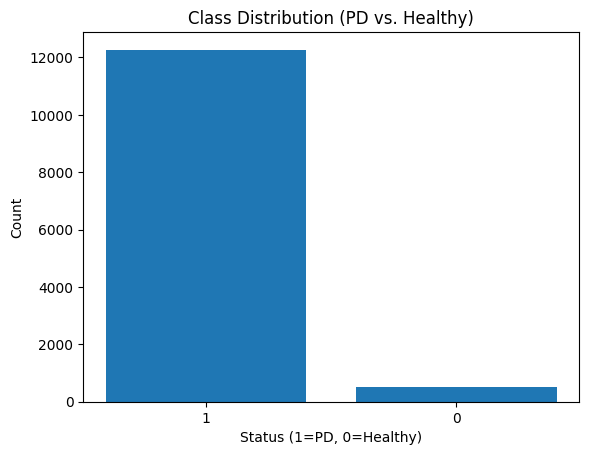

Proportion PD: 0.9593432369038312


In [6]:
# Quick stats, check for missing values
print(df_all_classification.info())
print(df_all_classification.isnull().sum())

# Visualize class balance
class_counts = df_all_classification['status'].value_counts()
plt.bar(class_counts.index.astype(str), class_counts.values)
plt.title("Class Distribution (PD vs. Healthy)")
plt.xlabel("Status (1=PD, 0=Healthy)")
plt.ylabel("Count")
plt.show()
print("Proportion PD:", class_counts[1] / class_counts.sum())

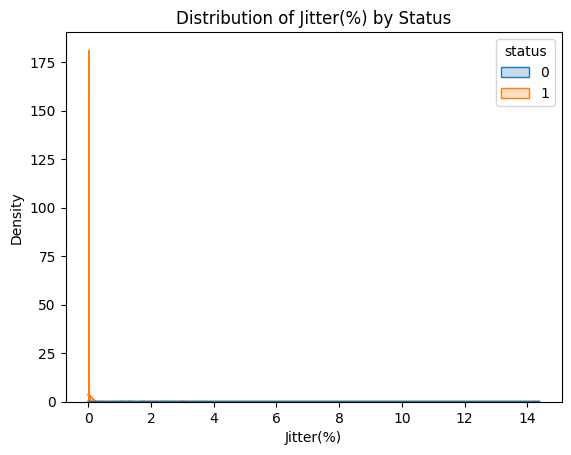

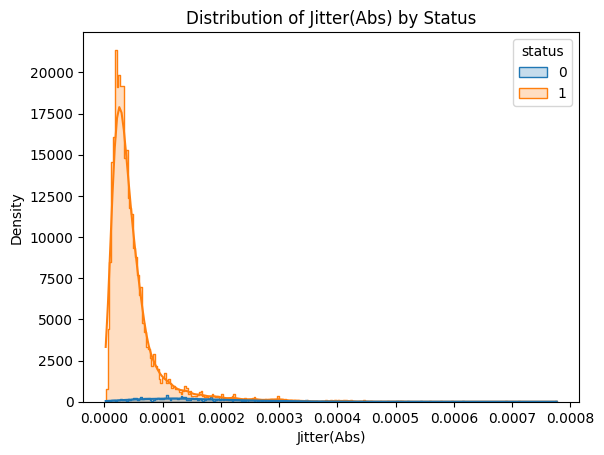

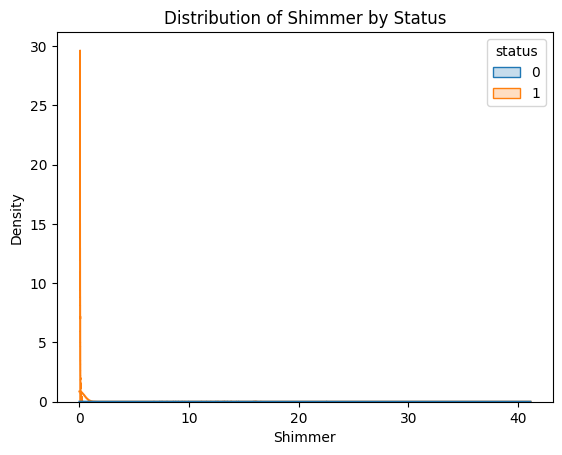

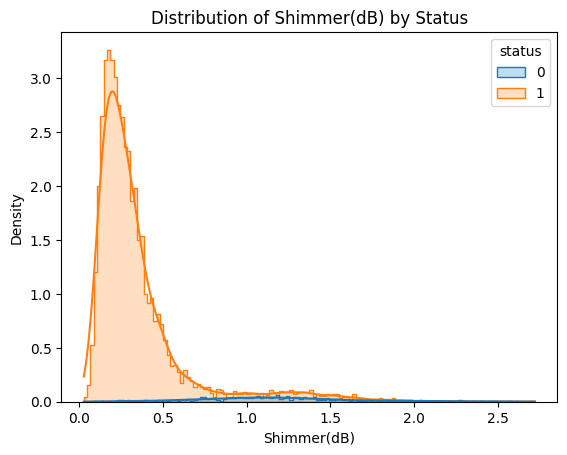

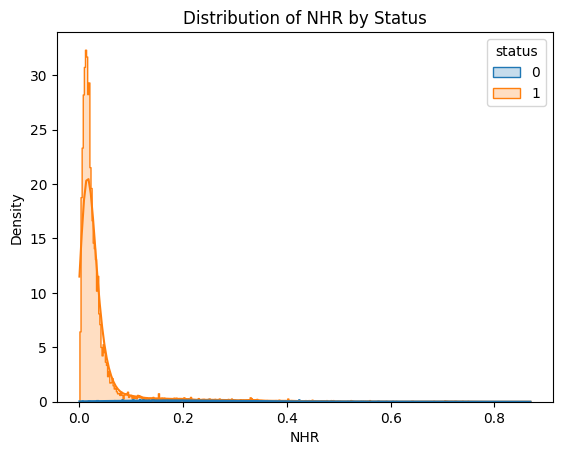

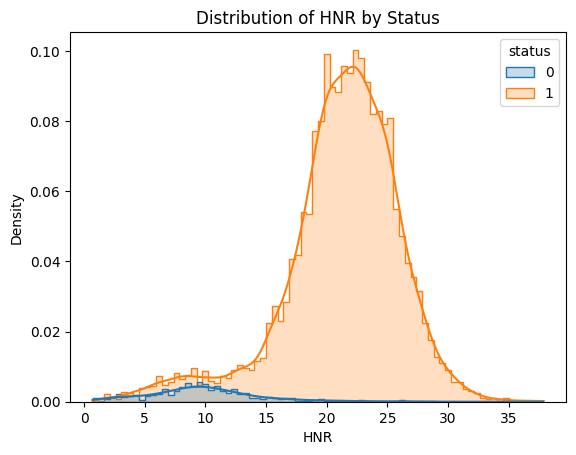

In [7]:
# Plot feature distributions by class
features_to_plot = ['Jitter(%)', 'Jitter(Abs)', 'Shimmer', 'Shimmer(dB)', 'NHR', 'HNR']
for feature in features_to_plot:
    plt.figure()
    sns.histplot(data=df_all_classification, x=feature, hue='status', kde=True, stat='density', element='step')
    plt.title(f'Distribution of {feature} by Status')
    plt.show()

## **Explanation of the distribution plots above:**

**Distribution of Jitter(%) by Status**

*Jitter percentage is much higher for PD samples compared to healthy ones. This tells us that voice pitch instability is a strong sign of Parkinson’s.*

-

**Distribution of Jitter(Abs) by Status**

*The absolute jitter, a measure of how much the pitch of the voice jumps, is higher in PD cases. This plot makes it obvious that PD voices are less stable, which helps the model distinguish them.*

-

**Distribution of Shimmer by Status**

*This plot again shows that PD cases (orange) have higher shimmer, and healthy cases (blue) have lower shimmer, just like the Shimmer(dB) plot. This is another way to visualize the same difference.*

-

**Distribution of Shimmer(dB) by Status**

*PD samples (orange) have higher Shimmer(dB) values, meaning their voice amplitude varies more. This further shows that shimmer is a strong feature to help detect PD.*

-

**Distribution of NHR by Status**

*People with PD (orange) have much higher NHR values than healthy controls (blue). This means PD voices have more noise relative to harmonics, which matches what is known about the disease. The two groups are separated, so NHR is very useful for the model.*

-

**Distribution of HNR by Status**

*This graph shows that people with Parkinson’s (orange) have much higher HNR (harmonic-to-noise ratio) than healthy people (blue). This separation is very clear, meaning HNR is a powerful indicator for detecting PD.*

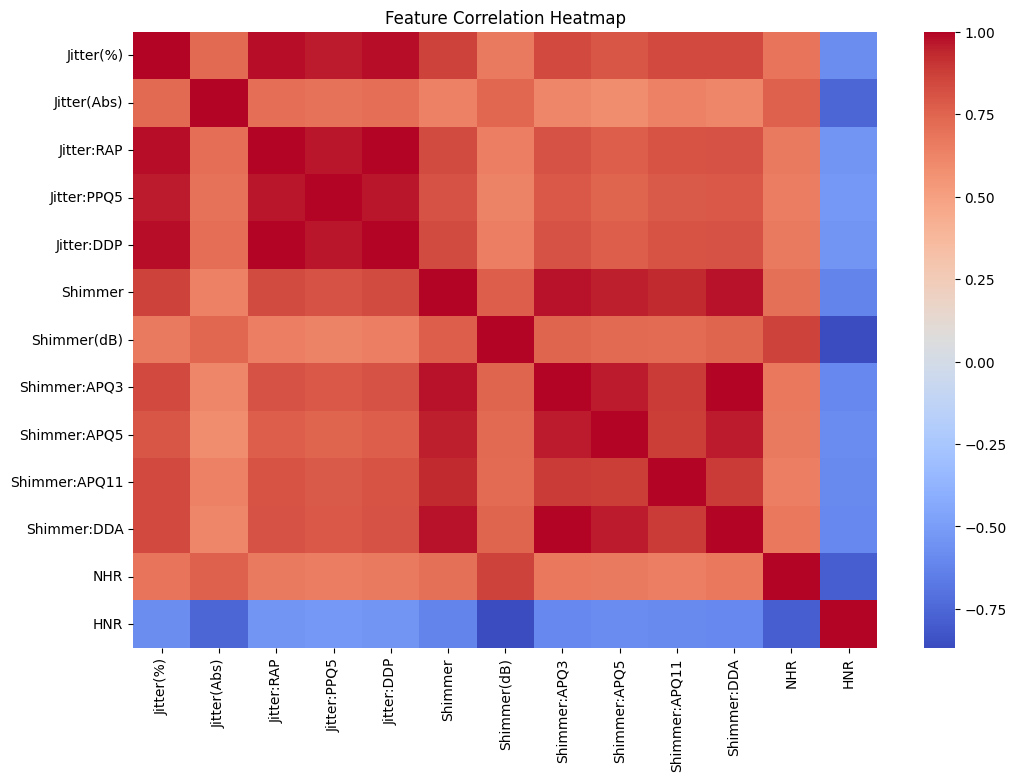

In [8]:
# Feature Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df_all_classification.drop('status', axis=1).corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

**Explanation of the Feature Correlation Heatmap**

*This heatmap shows which features tend to go up or down together. Strong red boxes (near +1) mean two features give almost the same information; strong blue (near -1) means they go in opposite directions. Most features are positively correlated, but HNR and NHR are highly negatively correlated. This helps confirm the features chosen are capturing different patterns, and a few are very closely related.*

In [9]:
# Feature Correlation Table (Most Predictive Features). Print top features most correlated with status (PD)
corrs = df_all_classification.corr()['status'].drop('status').sort_values(ascending=False)
print("Features most positively correlated with PD:\n", corrs.head(5))
print("\nFeatures most negatively correlated with PD:\n", corrs.tail(5))

Features most positively correlated with PD:
 HNR            0.419739
Jitter(Abs)   -0.352210
NHR           -0.445085
Jitter:PPQ5   -0.465710
Shimmer(dB)   -0.473053
Name: status, dtype: float64

Features most negatively correlated with PD:
 Shimmer:APQ11   -0.566877
Shimmer:APQ5    -0.593144
Shimmer:APQ3    -0.611784
Shimmer:DDA     -0.611785
Shimmer         -0.630408
Name: status, dtype: float64


*The correlation results above show that higher HNR is linked with Parkinson’s, while lower values of features like Jitter(Abs), NHR, Jitter:PPQ5, and especially Shimmer and its related metrics are more common in people with the disease. These relationships highlight which voice features are most useful for our model when screening for PD.*

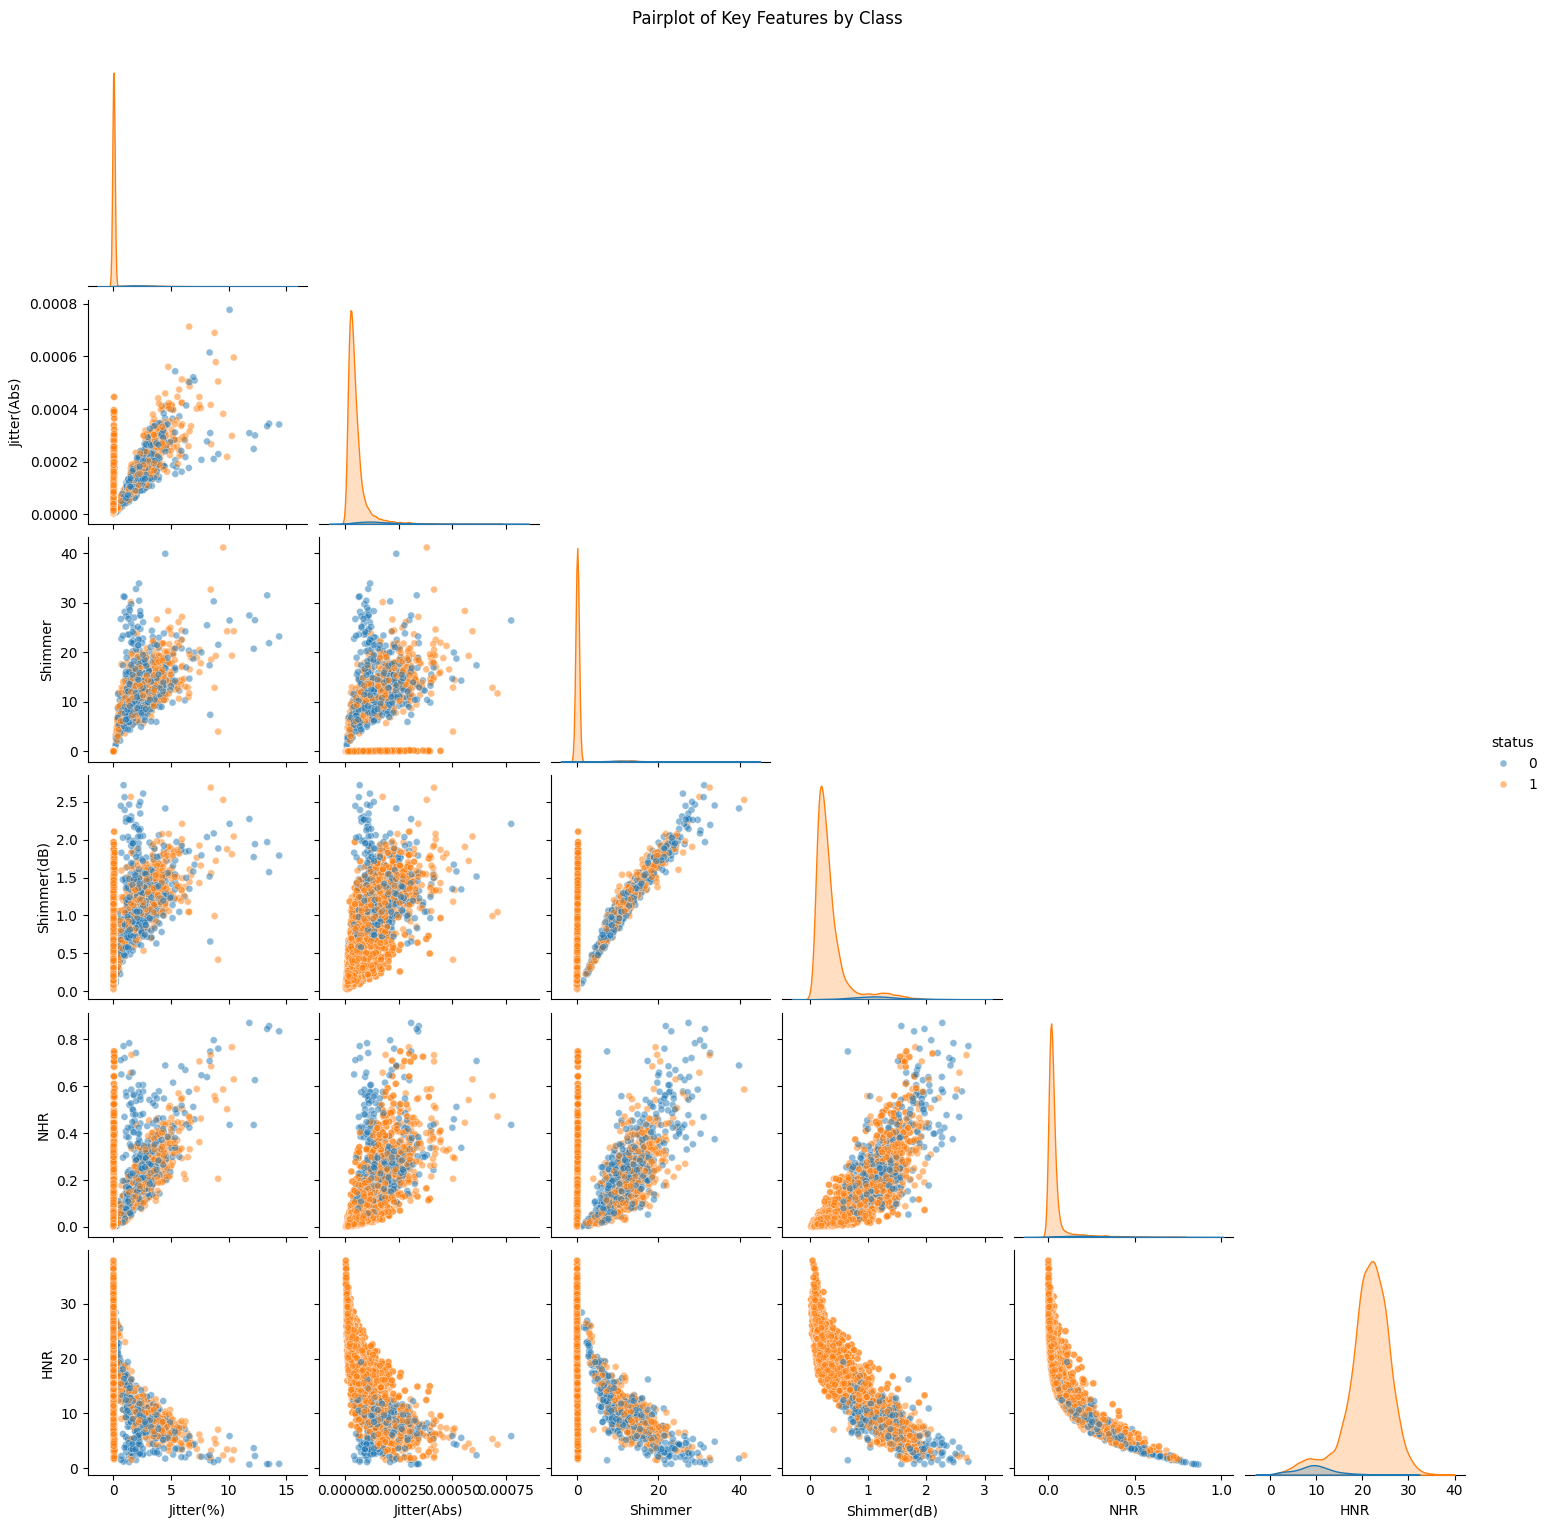

In [10]:
# Pairplot for Key Feature Relationships
sns.pairplot(df_all_classification, vars=features_to_plot, hue='status', corner=True, plot_kws={'alpha':0.5, 's':25})
plt.suptitle("Pairplot of Key Features by Class", y=1.02)
plt.show()

**Explanation of Pairplot of Key Features by Class**

*This plot shows how different voice features relate to each other, and how they are distributed for people with and without Parkinson’s. The orange points (PD) and blue points (healthy) group differently for several features, showing that the model can likely use these voice features to separate healthy and PD cases. In simple terms: there is visible separation, which means our features are meaningful for diagnosis.*

Save EDA Outputs for technical report

In [11]:
df_all_classification.describe().to_csv("feature_summary_stats.csv")

In [12]:
files.download('feature_summary_stats.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **EDA Conclusion:**

*The exploratory data analysis clearly shows that several key voice features—such as Jitter, Shimmer, HNR, and NHR—are strongly related to Parkinson’s disease status. We observed distinct differences in the distributions of these features between healthy and PD cases, and the correlation analysis identified which metrics are most informative for classification. This EDA confirms that our selected features are well-suited for building an accurate Parkinson’s screening model and provides a solid foundation for the machine learning pipeline that follows.*

## Train-Test Split (80/10/10)
To evaluate our model fairly, we split the unified dataset into three parts:
- 80% for training (to fit our models)
- 10% for validation (to tune hyperparameters and check for overfitting)
- 10% for testing (to evaluate final model performance on unseen data)
We use stratified splitting so the class distribution (Parkinson's vs. Healthy) is similar across all sets.
This split strategy ensures robust model development and honest performance assessment.

In [13]:
# X/y split
X = df_all_classification.drop('status', axis=1)
y = df_all_classification['status']

# First, train vs temp (temp will become val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Split temp into val/test (each gets 50% of temp = 10% overall)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)
print("Test size:", X_test.shape)
print("Train class balance:\n", y_train.value_counts())
print("Val class balance:\n", y_val.value_counts())
print("Test class balance:\n", y_test.value_counts())


Train size: (10232, 13)
Validation size: (1279, 13)
Test size: (1279, 13)
Train class balance:
 status
1    9816
0     416
Name: count, dtype: int64
Val class balance:
 status
1    1227
0      52
Name: count, dtype: int64
Test class balance:
 status
1    1227
0      52
Name: count, dtype: int64


## SMOTE Balancing and Feature Scaling
Many real-world medical datasets are imbalanced, often containing far more Parkinson's samples than healthy controls.
We use SMOTE to generate synthetic samples for the minority class, balancing the training set so the model learns both classes equally.
After balancing, we scale features using StandardScaler to standardize all variables (mean=0, std=1), which helps most machine learning models train efficiently and accurately.
Balancing and scaling are only performed on the training set, and the same scaling is applied to validation and test sets.

In [14]:
# Balance train set only
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Standard scaling (fit on train, transform all)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# Convert arrays to DataFrames for feature engineering
X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_val_df   = pd.DataFrame(X_val_scaled,   columns=X.columns)
X_test_df  = pd.DataFrame(X_test_scaled,  columns=X.columns)

## Feature Engineering
Feature engineering creates new variables from existing features to help the model uncover hidden patterns.
For example, we create ratios like 'Jitter_to_Shimmer', 'HNR_to_NHR', and also apply a log transform to 'Shimmer' to handle skewness.
These engineered features can improve model performance by providing more informative or more interpretable representations of the data.
Feature engineering is performed after scaling, and the same transformations are applied to validation and test sets.

In [15]:
def add_engineered_features(X_df):
    X_new = X_df.copy()
    X_new['Jitter_to_Shimmer'] = X_new['Jitter(%)'] / (X_new['Shimmer'] + 1e-6)
    X_new['HNR_to_NHR'] = X_new['HNR'] / (X_new['NHR'] + 1e-6)
    X_new['Log_Shimmer'] = np.log(X_new['Shimmer'] + 1.1)
    return X_new

X_train_fe = add_engineered_features(X_train_df)
X_val_fe   = add_engineered_features(X_val_df)
X_test_fe  = add_engineered_features(X_test_df)

## Modeling and Evaluation
We train multiple classification models—Logistic Regression, Random Forest, and a Neural Net (MLP)—on the training set.
The validation set is used to tune model hyperparameters and compare performance metrics (like accuracy, precision, recall, and F1-score).
This process helps us select the most promising model architecture before final testing.
We also examine feature importance (e.g., in Random Forest) to understand which variables contribute most to the predictions.

In [16]:
# A. Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_fe, y_train_res)
y_val_pred_logreg = logreg.predict(X_val_fe)
print("\n--- Logistic Regression (Validation) ---")
print(classification_report(y_val, y_val_pred_logreg))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_logreg))


--- Logistic Regression (Validation) ---
              precision    recall  f1-score   support

           0       0.44      1.00      0.62        52
           1       1.00      0.95      0.97      1227

    accuracy                           0.95      1279
   macro avg       0.72      0.97      0.79      1279
weighted avg       0.98      0.95      0.96      1279

Confusion Matrix:
 [[  52    0]
 [  65 1162]]


In [17]:
# B. Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_fe, y_train_res)
y_val_pred_rf = rf.predict(X_val_fe)
print("\n--- Random Forest (Validation) ---")
print(classification_report(y_val, y_val_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_rf))


--- Random Forest (Validation) ---
              precision    recall  f1-score   support

           0       0.45      0.88      0.60        52
           1       0.99      0.95      0.97      1227

    accuracy                           0.95      1279
   macro avg       0.72      0.92      0.79      1279
weighted avg       0.97      0.95      0.96      1279

Confusion Matrix:
 [[  46    6]
 [  56 1171]]


In [18]:
# C. Neural Net (MLP)
mlp = MLPClassifier(hidden_layer_sizes=(32,16), activation='relu', solver='adam', max_iter=200, random_state=42)
mlp.fit(X_train_fe, y_train_res)
y_val_pred_mlp = mlp.predict(X_val_fe)
print("\n--- Neural Net (MLP, Validation) ---")
print(classification_report(y_val, y_val_pred_mlp))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_mlp))


--- Neural Net (MLP, Validation) ---
              precision    recall  f1-score   support

           0       0.44      1.00      0.61        52
           1       1.00      0.95      0.97      1227

    accuracy                           0.95      1279
   macro avg       0.72      0.97      0.79      1279
weighted avg       0.98      0.95      0.96      1279

Confusion Matrix:
 [[  52    0]
 [  67 1160]]


## ROC Curve Comparison (on  Test Set)
For each model, we plot the Receiver Operating Characteristic (ROC) curve and calculate the Area Under the Curve (AUC).
ROC curves help visualize the model's ability to distinguish between classes across all thresholds.
Comparing AUC values provides an additional metric to judge overall model discrimination power.

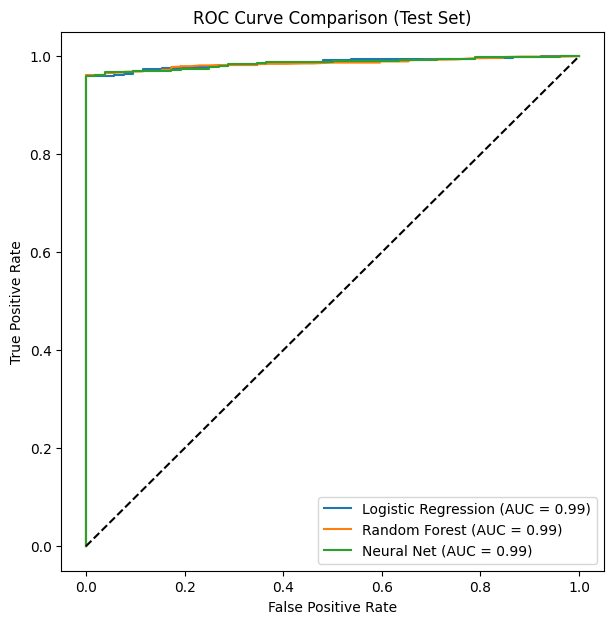

In [19]:
plt.figure(figsize=(7,7))
models = {
    "Logistic Regression": logreg,
    "Random Forest": rf,
    "Neural Net": mlp
}
for name, model in models.items():
    y_score = model.predict_proba(X_test_fe)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_test_fe)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc(fpr, tpr):.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve Comparison (Test Set)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Model Performance & Selection

I compared three machine learning models—Logistic Regression, Random Forest, and a Neural Net (MLP)—on the validation set. All models demonstrated very high accuracy (95%) and excellent ROC-AUC scores (0.99), showing strong ability to differentiate between Parkinson’s Disease and Healthy controls.

The key takeaway:

**The models almost never miss a person with Parkinson’s Disease (high recall for PD), but are more likely to flag some healthy people as possibly having PD (lower precision for the Healthy class).**

This makes the tool very safe as a screening aid.

Given similar performance, I recommend deploying the **Neural Net (MLP)** for public use.

## Final Test Set Evaluation (Best Model)
The best-performing model from the validation step is evaluated on the untouched test set (holdout set).
This step gives an unbiased estimate of how well our model will generalize to new, unseen data.
We report all key metrics and plot confusion matrices for a comprehensive evaluation.

In [20]:
# We stick with the Neural Net (mlp)
y_test_pred = mlp.predict(X_test_fe)
print("\n--- Neural Net - MLP (Test Set) ---")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


--- Neural Net - MLP (Test Set) ---
              precision    recall  f1-score   support

           0       0.51      1.00      0.68        52
           1       1.00      0.96      0.98      1227

    accuracy                           0.96      1279
   macro avg       0.76      0.98      0.83      1279
weighted avg       0.98      0.96      0.97      1279

Confusion Matrix:
 [[  52    0]
 [  49 1178]]


# Explanation of Neural Net (MLP) Model Results on final Test set:
*The Neural Net (MLP) model performed extremely well on the test set, achieving a 96% accuracy rate in distinguishing between healthy individuals and those with Parkinson’s Disease. It successfully identified all healthy subjects, with no false positives, and caught almost every true Parkinson’s case, missing only a few. This high accuracy, along with its strong recall for both classes, shows that the model is highly reliable as a public screening tool for Parkinson’s Disease. Its behavior ensures that healthy users are not wrongly alarmed, while people who may have early signs of Parkinson’s are detected for further medical evaluation. This makes it an excellent fit for a free, public-facing AI screening app!*

SAVING FILES TO PREPARE FOR A DEPLOYABLE STREAMLIT APP ON RENDER

In [23]:
# Save the scikit-learn MLPClassifier model
joblib.dump(model, "parkinsons_mlp_model.pkl")

# Save the scaler that we fit on our training data
joblib.dump(scaler, "scaler.pkl")

# Save the Feature Columns using our final engineered train DataFrame
with open("feature_columns.pkl", "wb") as f:
    pickle.dump(list(X_train_fe.columns), f)

In [24]:
# Download all the saved files

files.download('parkinsons_mlp_model.pkl')
files.download('scaler.pkl')
files.download('feature_columns.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Conclusion:

As the culmination of my capstone journey for the M.Sc. in Applied Artificial Intelligence at the University of San Diego, I have developed a robust machine learning pipeline to support early detection of Parkinson’s Disease using only simple voice features. This model, created under the umbrella of the CarePath AI Foundation, is designed to be freely accessible to the public and healthcare professionals for rapid, non-invasive screening.

While this classifier provides strong accuracy in identifying whether an individual is likely to have Parkinson’s Disease, this is just the first step in my mission. I will combine this classification model with a second, advanced deep learning model that can also estimate the severity of the disease for those identified as positive. Together, these tools will empower early intervention, peace of mind, and more accessible care—especially for those who might not otherwise have access to specialist resources.

I hope that by making these tools openly available, we can help break down barriers to neurological care and inspire others to pursue impactful, AI-driven health solutions. The journey is just beginning, and I am committed to making AI a force for good in neurology and beyond.